<a href="https://colab.research.google.com/github/cyamonide/cs445-pix2pixzero/blob/siliu%2Fedit-directions/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/pix2pix-zero

Mounted at /content/drive
/content/drive/MyDrive/pix2pix-zero


In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)
!python --version

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install tensorflow[and-cuda]
!pip install tensorrt accelerate diffusers==0.12.0 einops gradio ipython numpy opencv-python-headless pillow psutil tqdm transformers
!pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install salesforce-lavis

## **Method**
Overview: First, text captions are generated from an input image via BLIP, followed by the creation of an inverse noise map through regularized DDIM inversion. Reference cross-attention maps are then produced to match the image structure, guided by CLIP embeddings of the generated text. Denoising with edited text embeddings ensues, with a focus on aligning current cross-attention maps with the reference ones.
<br>
<br>
<img src="https://pix2pixzero.github.io/assets/method_cat.jpg" width=1500 />
<br>

### **1. Inverting Real Images**
The paper adopts the deterministic DDIM reverse process fro inverting real images into their latent representations. The key steps include:


*   Preparation of the input image and latents
*   Implementation of deterministic DDIM reverse process ([Denoising Diffusion Implicit Models](https://arxiv.org/pdf/2010.02502.pdf))
<br> Inversion entails finding a noise map $x_{inv}$ that reconstructs the input latent code $x_0$ upon sampling. The deterministic DDIM reverse process shows below:
$$ x_{t+1} = \sqrt{\alpha_{t+1}^{-}}f_{\theta}(x_t, t, c) + \sqrt{1-\alpha_{t+1}^{-}}\epsilon_{\theta}(x_t, t, c) $$
where $x_t$ is noised latent code at timestep t, $\epsilon_\theta (x_t , t, c)$ is a UNet-based denoiser that predicts added noise in $x_t$ conditional on timestep t and encoded text features c, $\alpha_{t+1}^{-}$ is noise scaling factor as defined in DDIM, and $f_{\theta}(x_t, t, c)$ predicts the final denoised latent code $x_0$.
$$f_{\theta}(x_t, t, c) = \frac{x_t - \sqrt{1-\alpha_t^{-}}\epsilon_{\theta}(x_t, t, c)}{\sqrt{\alpha_t^{-}}} $$
* Noise regularization
<br> - Auto-correlation regularization $L_{pair}$
$$
L_{pair} = \sum_{p} \frac{1}{S_{p}^{2}} \sum_{\delta=1}^{S_{p}-1} \sum_{x,y,c} \eta^{p}_{x,y,c} (\eta^{p}_{x-\delta,y,c} + \eta^{p}_{x,y-\delta,c}),
$$
<br> - KL Divergence regularization $L_{KL}$
<br> - Final autocorrelation regularization $L_{auto} = L_{pair} + \lambda L_{KL}$
* Image reconstruction





In [ ]:
import sys
import numpy as np
import torch
import torch.nn.functional as F
from random import randrange
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from diffusers import DDIMScheduler
from diffusers.schedulers.scheduling_ddim import DDIMSchedulerOutput
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from src.utils.base_pipeline import BasePipeline
from src.utils.cross_attention import prep_unet

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

class DDIMInversion(BasePipeline):
  def __call__(
    self,
    prompt: Union[str, List[str]] = None,
    num_inversion_steps: int = 50,
    guidance_scale: float = 7.5,
    negative_prompt: Optional[Union[str, List[str]]] = None,
    num_images_per_prompt: Optional[int] = 1,
    eta: float = 0.0,
    output_type: Optional[str] = "pil",
    return_dict: bool = True,
    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    img=None,
    torch_dtype=torch.float32,

    # inversion regularization parameters
    lambda_kl: float = 20.0,
    num_reg_steps: int = 5,
    num_ac_rolls: int = 5,
):
    self.unet = prep_unet(self.unet)
    device = self._execution_device
    do_classifier_free_guidance = guidance_scale > 1.0

    # Prepare the input image and encode to latent space
    x0 = self.prep_img(img, device, torch_dtype)
    x0_enc = self.encode_latents(x0, device, torch_dtype)

    # Decode
    with torch.no_grad():
      x0_dec = self.decode_latents(x0_enc.detach())
    image_x0_dec = self.numpy_to_pil(x0_dec)

    # DDIM inversion
    prompt_embeds = self._encode_prompt(prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt).to(device)
    extra_step_kwargs = self.prepare_extra_step_kwargs(None, eta)

    latents = x0_enc
    latents = self.perform_inversion(x0_enc, num_inversion_steps, device, torch_dtype, prompt_embeds, extra_step_kwargs, \
    do_classifier_free_guidance, cross_attention_kwargs, guidance_scale, num_reg_steps, lambda_kl, num_ac_rolls, latents)

    x_inv = latents.detach().clone()

    # Decode the latent back to image space
    img = self.decode_latents(latents.detach())
    img = self.numpy_to_pil(img)

    return x_inv, img, image_x0_dec

  # prepare the input image
  def prep_img (self, img, device, torch_dtype):
    x0 = np.array(img) / 255
    x0 = torch.from_numpy(x0).type(torch_dtype).permute(2, 0, 1).unsqueeze(0).repeat(1, 1, 1, 1).to(device)
    return (x0 - 0.5) * 2

  # encode to latent space
  def encode_latents(self, x0, device, torch_dtype):
    with torch.no_grad():
      # vae: AutoencoderKL
      x0_enc = self.vae.encode(x0).latent_dist.sample().to(device, torch_dtype)
    # normalization
    return 0.18215 * x0_enc

  # perform the DDIM inversion
  def perform_inversion(self, x0_enc, num_inversion_steps, device, torch_dtype, prompt_embeds, \
  extra_step_kwargs, do_classifier_free_guidance, cross_attention_kwargs, guidance_scale, \
  num_reg_steps, lambda_kl, num_ac_rolls, latents):
    # set timesteps
    self.scheduler.set_timesteps(num_inversion_steps, device=device)
    timesteps = self.scheduler.timesteps

    num_warmup_steps = len(timesteps) - num_inversion_steps * self.scheduler.order
    with self.progress_bar(total=num_inversion_steps) as progress_bar:
      for i, t in enumerate(timesteps.flip(0)[1:-1]):
        # implementation of classifier-free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

        # alpha_t: adjusts the input latents according to a noise schedule
        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

        # e_t: a U-Net model (f_theta) predicts the noise for the given timesteps
        with torch.no_grad():
            noise_pred = self.unet(latent_model_input,t,encoder_hidden_states=prompt_embeds,cross_attention_kwargs=cross_attention_kwargs,).sample
        # print(f"noise_pred before regularization: {noise_pred} \n")

        noise_pred = self.apply_regularization(noise_pred, lambda_kl, do_classifier_free_guidance, \
        guidance_scale, num_reg_steps, num_ac_rolls)
        # print(f"noise_pred after regularization: {noise_pred} \n")

        # x_t steps back towards x_{t-1}: updates the latents by removing the noise epsilon_{\theta}
        latents = self.scheduler.step(noise_pred, t, latents, reverse=True, **extra_step_kwargs).prev_sample

        # callback
        if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
            progress_bar.update()

    return latents

  # apply auto-correclation and KL divergence regularization
  def apply_regularization(self, noise_pred, lambda_kl, do_classifier_free_guidance, guidance_scale, num_reg_steps, num_ac_rolls):
    # perform guidance
    if do_classifier_free_guidance:
        # split the noise predcition tensor into two parts: one unconditioned and one conditioned on text
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # regularization of the noise prediction
    e_t = noise_pred
    for _ in range(num_reg_steps):
      e_t = self.regularize_noise(e_t,lambda_kl, num_ac_rolls)
    return e_t

  def regularize_noise(self, e_t, lambda_kl, num_ac_rolls):
    for _ in range(num_ac_rolls):
      e_t = self.apply_auto_corr_loss(e_t)
      if lambda_kl > 0:
          e_t = self.apply_kl_divergence_loss(e_t, lambda_kl)
    return e_t

  # def apply_auto_corr_loss(self, e_t, lambda_ac):
  #   var = e_t.detach().clone().requires_grad_(True)
  #   # compute the auto_corr_loss
  #   l_ac = self.auto_corr_loss(var)
  #   # compute the gradients and store the gradients in var.grad
  #   l_ac.backward()
  #   grad = var.grad.detach()

  #   return e_t - lambda_ac * grad

  def apply_auto_corr_loss(self, e_t):
    e_t.requires_grad_(True)
    # use SGD optimizer
    optimizer = torch.optim.SGD([e_t], lr=0.1)
    optimizer.zero_grad()
    # calculate the auto_corr_loss
    l_ac = self.auto_corr_loss(e_t)
    # calculate gradients
    l_ac.backward()
    optimizer.step()
    e_t.detach_()

    return e_t

  # L_pair
  def auto_corr_loss(self, x, random_shift=True):
    B, C, H, W = x.shape
    assert B == 1
    # [C, H, W]
    x = x.squeeze(0)

    reg_loss = 0.0
    for channel in x:
      # [1, 1, H, W]
      noise = channel.unsqueeze(0).unsqueeze(0)
      # H == W
      current_size = noise.size(2)

      while current_size >= 8:
        if random_shift and current_size > 1:
          roll_amount_h = randrange(current_size // 2)
          roll_amount_w = randrange(current_size // 2)
        else:
          roll_amount_h, roll_amount_w = 1, 1

        # Compute autocorrelation for shifted tensors in both dimensions
        rolled_h = torch.roll(noise, shifts=roll_amount_h, dims=2)
        rolled_w = torch.roll(noise, shifts=roll_amount_w, dims=3)
        reg_loss += (noise * rolled_h).mean().pow(2)
        reg_loss += (noise * rolled_w).mean().pow(2)

        # Reduce size by pooling
        noise = F.avg_pool2d(noise, kernel_size=2)
        current_size = noise.size(2)

    return reg_loss

  def apply_kl_divergence_loss(self, e_t, lambda_kl):
    var = e_t.detach().clone().requires_grad_(True)
    # compute the auto_corr_loss
    l_kld = self.kl_divergence(var)
    # compute the gradients and store the gradients in var.grad
    l_kld.backward()
    grad = var.grad.detach()
    return e_t - lambda_kl * grad

  # calculate the KL divergence for regularization
  def kl_divergence(self, x):
    _mu = x.mean()
    _var = x.var()

    # KL divergence for Gaussian distribution with mean=0 and variance=1
    return _var + _mu**2 - 1 - torch.log(_var + 1e-7)

### **2. Discovering Edit Directions**

In [ ]:
import re
from transformers import T5Tokenizer, T5ForConditionalGeneration

"""
Remove any undesirable characters that might affect edit direction generation.
"""
def clean_sentences(sentences):
  characters_to_remove = "012345679.,'-():!"
  cleaned_sentences = sentences

  for c in characters_to_remove:
    cleaned_sentences = [s.replace(c, "") for s in cleaned_sentences]

  cleaned_sentences = [s.strip().lower() for s in cleaned_sentences]

  return cleaned_sentences

"""
Use Google's Flan T5 XL model to generate :num: sentences containing a
particular word. By default, 1024 sentences are generated since ~1000 is
recommended for reasonable results:
https://github.com/pix2pixzero/pix2pix-zero/issues/16#issuecomment-1485394203
"""
def compute_sentences(word, count=1024):
  model_name = "google/flan-t5-xl"
  prompt = f"Provide a caption for images containing {word}. The captions should be in English and be shorter than 150 characters. The caption must contain the word {word}."

  tokenizer = T5Tokenizer.from_pretrained(model_name)
  model = T5ForConditionalGeneration.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

  prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
  prompt_length = prompt_ids.shape[1]

  sentences = []

  while len(sentences) < count:
    try:
      output_ids = model.generate(
          prompt_ids,
          do_sample=True,
          num_return_sequences=8,
          max_length=128,
          min_length=15
      )
      output = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    except:
      continue

    sentences += output

    print(f"{len(sentences)}/{count} generated.")

  # clean
  sentences = clean_sentences(sentences)

  del model
  del tokenizer
  torch.cuda.empty_cache()

  return sentences

In [ ]:
word = "horse"
sentences = compute_sentences(word, 1024)

In [ ]:
with open(f"sentences/{word}.txt", 'w') as f:
  for s in sentences:
    f.write(f"{s}\n")

In [ ]:
import os
from transformers import CLIPTokenizer, CLIPTextModel
from src.utils.edit_pipeline import EditingPipeline

def get_edit_direction(task_name):
  task_from = task_name.split('2')[0]
  task_to = task_name.split('2')[1]

  model_name = "CompVis/stable-diffusion-v1-4"

  pipe = EditingPipeline.from_pretrained(model_name, torch_dtype=torch.float16).to(device)

  tokenizer = pipe.tokenizer
  encoder = pipe.text_encoder

  # tokenizer = CLIPTokenizer.from_pretrained(model_name)
  # encoder = CLIPTextModel.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

  # Create embeddings
  for thing in task_name.split('2'):
    sentence_filepath = f"sentences/{thing}.txt"
    embedding_filepath = f"assets/embeddings_sd_1.4/{thing}.pt"

    # Skip embedding generation if it already exists
    if os.path.exists(embedding_filepath):
      print(f"{embedding_filepath} already exists, skipping generation!")
      continue

    with open(sentence_filepath, 'r') as f:
      sentences = [l.strip() for l in f.readlines()]

    sentence_embeddings = []

    with torch.no_grad():
      for s in sentences:
        sentence_t = tokenizer(
            s,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        sentence_ids = sentence_t.input_ids
        embeds = encoder(sentence_ids.to(device), attention_mask=None)[0]
        sentence_embeddings.append(embeds)

        # memory mgmt
        del sentence_ids

      average_embeddings = torch.concatenate(sentence_embeddings, dim=0).mean(dim=0).unsqueeze(0)

      print(f"Saving embeddings file {embedding_filepath}...")
      torch.save(average_embeddings, embedding_filepath)

  del tokenizer
  del encoder
  del pipe

  # Compute difference between embeddings
  from_embeddings = torch.load(f"assets/embeddings_sd_1.4/{task_from}.pt", map_location=device)
  to_embeddings = torch.load(f"assets/embeddings_sd_1.4/{task_to}.pt", map_location=device)

  difference = (to_embeddings.mean(0) - from_embeddings.mean(0)).unsqueeze(0)

  return difference

In [ ]:
get_edit_direction("car2horse")

In [ ]:
! python src/edit_synthetic.py \
    --results_folder "output/synth_editing_car" \
    --prompt_str "a high resolution photo of the side of a car" \
    --task "car2horse"\
    --use_float_16

break

In [ ]:
! python src/make_edit_direction.py \
        --file_source_sentences sentences/pineapple.txt \
        --file_target_sentences sentences/strawberry.txt \
        --output_folder assets/embeddings_sd_1.4

In [ ]:
! python src/inversion.py  \
        --input_image "assets/test_images/pineapples/pineapple_1.jpg" \
        --results_folder "output/test_pineapple_3"

In [ ]:
! python src/edit_real.py \
    --inversion "output/test_pineapple_3/inversion/pineapple_1.pt" \
    --prompt "output/test_pineapple_3/prompt/pineapple_1.txt" \
    --task_name "pineapple2strawberry" \
    --results_folder "output/test_pineapple_3/"\
    --use_float_16 \
    --edit_direction_multiplier 5

### **3. Editing via Cross-Attention Guidance**

### **4. Evaluations**
#### **4.1 Quantitative evaluations**
For quantitative evaluations, we use three metrics.
*   **CLIP Acc:** measuring whether the edit is applied successfully by assessing alignment with target attributes. (Hessel, Jack, et al. [CLIPScore](https://aclanthology.org/2021.emnlp-main.595v2.pdf))
*   **Structure Dist:**  measuring whether the structure of the input and edited image is consistent (Tumanyan, Narek, et al. [Splicing ViT](https://openaccess.thecvf.com/content/CVPR2022/papers/Tumanyan_Splicing_ViT_Features_for_Semantic_Appearance_Transfer_CVPR_2022_paper.pdf)).
*   **Background LPIPS error:** measuring if the background regions of the image stay unchanged after edits by calculating the background (Zhou, Xingyi, et al. [Detic](https://arxiv.org/pdf/2201.02605)).




**1. CLIP Acc**\
We evaluate the CLIPScore by using the official code for the EMNLP 2021 paper: "CLIPScore: A Reference-free Evaluation Metric for Image Captioning".

In [ ]:
%cd '/content/drive/MyDrive'
!git clone https://github.com/jmhessel/clipscore.git

!pip install git+https://github.com/openai/CLIP.git
!pip install git+https://github.com/jmhessel/pycocoevalcap.git

%cd clipscore

In [ ]:
"""
Measure the extend of the edit with CLIP Acc by calculating the percentage of instances where the edited image
has a higher similarity to the target text than to the original source text.
"""
! python clipscore.py "../scoreTest/caption.json" "../scoreTest/images"

\# the edited image to the target text\
{"cat_7_output": "a painting of a dog sitting in a field of flowers"} \
CLIPScore: 0.8647
\
\
\# the edited image to the original text\
{"cat_7_output": "a painting of a cat sitting in a field of flowers"} \
CLIPScore: 0.7051

Notes: to run the above code, the input files are formatted as follows:
*   The candidates json should be a dictionary that maps from {"string_image_identifier": "candidate"}, e.g., {"cat_7_output": "a painting of a dog sitting in a field of flowers"}.
*   The image directory should be a directory containing the images that act as the keys in the candidates json.


**2. Structure Dist**
\
We implement the method described in the CVPR 2022 paper "Splicing ViT Features for Semantic Appearance Transfer" for measuring strucutural distance between two images using a pre-trained Vision Transformer (ViT) model.
\
$$ L_{structure} = \left\| S^{L}(I_s) - S^{L}(I_o) \right\|_F $$
\
The term $L_{structure}$ measures if the output image matches the structure of $I_s$, and is defined by the difference in self-similarity of the keys extracted from the attention module at deepest transformer layer, where $S^{L}(I_s)$ is defined as:
$$S^{L}(I)_{ij} = \text{cos-sim} \left( k^{L}_{i}(I), k^{L}_{j}(I) \right) $$
\
It leverages deep spatial features extracted from DINO-ViT, and use their self-similarity as structure representation. cos-sim is the cosine similarity between keys.

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


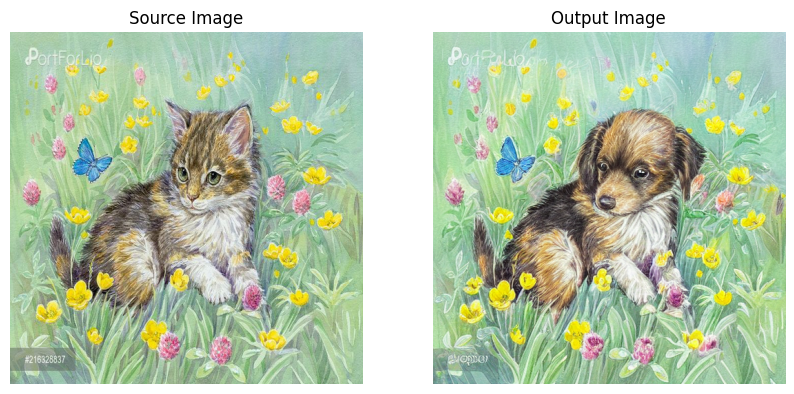

Structural Distance: 23.501304626464844


In [ ]:
import torch
from torch import nn
import cv2
from transformers import ViTModel, ViTFeatureExtractor
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

"""
Load DINO-Vit(self-distillation with no labels) self-supervised vision transformer
repo: https://github.com/facebookresearch/dino
"""
def load_pretrained_vit(model_name='facebook/dino-vitb8'):
    feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
    model = ViTModel.from_pretrained(model_name)
    model.eval()

    return feature_extractor, model

# Preprocess an image
def preprocess_image(image_path, feature_extractor):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs['pixel_values']

# Compute the self-similarity matrix
def compute_self_similarity(keys):
    keys_norm = torch.nn.functional.normalize(keys, p=2, dim=-1)
    cosine_similarity = torch.matmul(keys_norm, keys_norm.transpose(-2, -1))
    # print(cosine_similarity.shape)
    # print(f"cosine_similarity: {cosine_similarity}")

    return cosine_similarity

# Calculate the structural distance
def calculate_structure_distance(ss_matrix1, ss_matrix2):
    return torch.norm(ss_matrix1 - ss_matrix2, p='fro').item()

# Load model and feature extractor
feature_extractor, vit_model = load_pretrained_vit()

# Source and edited output images
source_image_path = '../distTest/cat_7.png'
output_image_path = '../distTest/cat_7_output.png'

# Preprocess images
source_inputs = preprocess_image(source_image_path, feature_extractor)
output_inputs = preprocess_image(output_image_path, feature_extractor)

with torch.no_grad():
    source_outputs = vit_model(source_inputs, output_attentions=True)
    output_outputs = vit_model(output_inputs, output_attentions=True)

    # Take the attention from the last layer for self-similarity calculation
    source_keys = source_outputs.attentions[-1]
    output_keys = output_outputs.attentions[-1]

    # Compute self-similarity matrices for source and output
    source_ss = compute_self_similarity(source_keys.mean(dim=1))
    output_ss = compute_self_similarity(output_keys.mean(dim=1))

    # Calculate structural distance
    structure_distance = calculate_structure_distance(source_ss, output_ss)

source_img = cv2.cvtColor(cv2.imread(source_image_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0
output_img = cv2.cvtColor(cv2.imread(output_image_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(source_img)
plt.title('Source Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_img)
plt.title('Output Image')
plt.axis('off')
plt.show()

print(f"Structural Distance: {structure_distance}")

**3. Background LPIPS error**
\
First, we use the Detic model implemented in the paper "Detecting Twenty-thousand Classes using Image-level Supervision" for identifying the background regions of the original and edited images.

In [ ]:
# environment setup
%cd /content/drive/MyDrive
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!pip install -e .

In [ ]:
%cd /content/drive/MyDrive
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
%cd Detic
!pip install -r requirements.txt
%cd third_party
!git clone https://github.com/xingyizhou/CenterNet2.git
!git clone https://github.com/fundamentalvision/Deformable-DETR.git

In [ ]:
# get Detic model
%cd /content/drive/MyDrive/Detic
%mkdir models
!wget https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth -O models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth

In [ ]:
# run the model
!python demo.py --config-file configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml --input ./models/cat_7.png --output ./models/output_0.png --vocabulary lvis --opts MODEL.WEIGHTS models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth
!python demo.py --config-file configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml --input ./models/cat_7_output.png --output ./models/output_1.png --vocabulary lvis --opts MODEL.WEIGHTS models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth

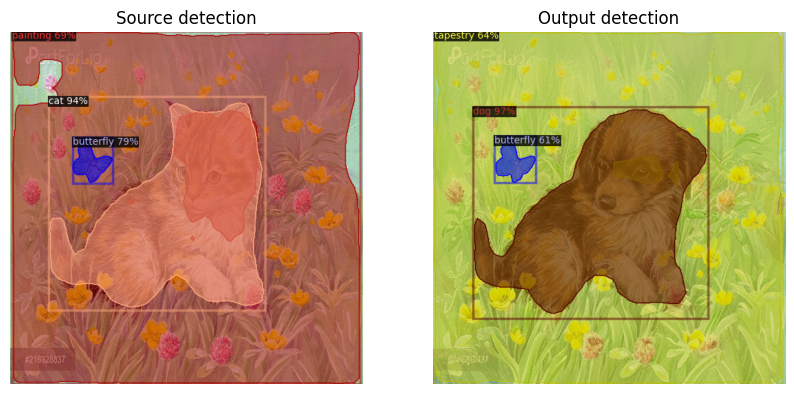

In [40]:
# Show Detic output
import cv2
import matplotlib.pyplot as plt

source_detic = './models/output_0.png'
output_detic = './models/output_1.png'

source_detection = cv2.cvtColor(cv2.imread(source_detic), cv2.COLOR_BGR2RGB).astype('double') / 255.0
output_detection = cv2.cvtColor(cv2.imread(output_detic), cv2.COLOR_BGR2RGB).astype('double') / 255.0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(source_detection)
plt.title('Source detection')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_detection)
plt.title('Output detection')
plt.axis('off')
plt.show()

Then we calculate the LPIPS distance between the background regions of the original and edited images using the outputs we've obtained from the Detic model by using the 'lpips' library.

In [ ]:
!pip install lpips

In [66]:
#FIX ME
import torch
import lpips
from PIL import Image
import torchvision.transforms as transforms

def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    return image

im1 = load_image('./models/output_0.png')
im2 = load_image('./models/output_1.png')

lpips_model = lpips.LPIPS(net='alex')

distance = lpips_model(im1, im2)
print("LPIPS Distance:", distance.item())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS Distance: 0.423190176486969


## **Running the code**

In [ ]:
! python src/inversion.py  \
        --input_image "assets/test_images/cats/cat_7.png" \
        --results_folder "output/test_cat"

In [ ]:
! python src/edit_real.py \
    --inversion "output/test_cat/inversion/cat_7.pt" \
    --prompt "output/test_cat/prompt/cat_7.txt" \
    --task_name "cat2dog" \
    --results_folder "output/test_cat/"\
    --use_float_16

In [ ]:
! python src/edit_synthetic.py \
    --results_folder "output/synth_editing" \
    --prompt_str "a high resolution painting of a cat in the style of van gogh" \
    --task "cat2dog"\
    --use_float_16